In [1]:
from gurobipy import Model, GRB
import gurobipy as gp
import numpy as np
from tqdm.notebook import tqdm

# Integer Programming

In [2]:
def solve_IP(H, N, a, tau, tau_mean, t, priorities, pr_weights, P, M = 1e5, fix_x=None):
    # suppress all console output
    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.start()
        with gp.Model(env=env) as m:
    
            # Decision Variables
            x = {}
            a_in = {}
            w = {}
            s = {}
            r = {}
            e = {}
            f = {}
            u = {}
        
            z = m.addVars(H, N, N, vtype=GRB.BINARY, name="z")
            v = m.addVars(H, N, N, vtype=GRB.BINARY, name="v")
            y = m.addVars(H, N, N, vtype=GRB.BINARY, name="y")
            d = m.addVars(H, N, N, vtype=GRB.BINARY, name="d")
            primal_obj = m.addVar(name="primal_obj")       
            
            for i in range(H):
                for n in range(N):
                    x[i, n] = m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{n}")
                    a_in[i, n] = m.addVar(name=f"a_in_{i}_{n}")
                    w[i, n] = m.addVar(name=f"w_{i}_{n}")
                    for k in range(N):
                        s[i, n, k] = m.addVar(vtype=GRB.BINARY, name=f"s_{i}_{n}_{k}")
                        r[i, n, k] = m.addVar(vtype=GRB.BINARY, name=f"r_{i}_{n}_{k}")
                        e[i, n, k] = m.addVar(vtype=GRB.BINARY, name=f"e_{i}_{n}_{k}")
                        f[i, n, k] = m.addVar(vtype=GRB.BINARY, name=f"f_{i}_{n}_{k}")
                        u[i, n, k] = m.addVar(vtype=GRB.BINARY, name=f"u_{i}_{n}_{k}")
    
            # Constraints
            for n in range(N):
                m.addConstr(sum(x[i, n] for i in range(H)) == 1)  # Each call is assigned to one hospital
                for i in range(H):
                    m.addConstr(a_in[i, n] == a[n] + t[i][n] * x[i, n])  # Arrival time at hospital
                    # m.addConstr(w[i, n] >= 1e-3) # trivial constraint
                    # Linearization constraints for z and v
                    for k in range(N):
                        if k != n:
                            m.addConstr(z[i, k, n] <= x[i, k])
                            m.addConstr(z[i, k, n] <= x[i, n])
                            m.addConstr(z[i, k, n] >= x[i, k] + x[i, n] - 1)
                            
                            m.addConstr(v[i, k, n] <= u[i, n, k])
                            m.addConstr(v[i, k, n] <= z[i, k, n])
                            m.addConstr(v[i, k, n] >= u[i, n, k] + z[i, k, n] - 1)
            
                            m.addConstr(y[i, k, n] <= r[i, n, k])       # r = 1: k arrive before n start service
                            m.addConstr(y[i, k, n] <= (1 - s[i, n, k])) # s = 0: n arrive before call k start service
                            m.addConstr(y[i, k, n] <= z[i, k, n])
                            m.addConstr(y[i, k, n] >= r[i, n, k] + (1 - s[i, n, k]) + z[i, k, n] - 2)
            
                            m.addConstr(d[i, k, n] <= e[i, n, k])       # e = 1: k arrive before n arrive
                            m.addConstr(d[i, k, n] <= (1 - s[i, n, k])) # s = 0: n arrive before call k start service
                            m.addConstr(d[i, k, n] <= z[i, k, n])
                            m.addConstr(d[i, k, n] >= e[i, n, k] + (1 - s[i, n, k]) + z[i, k, n] - 2)
    
                
                    # Total waiting time
                    waiting_due_to_ongoing_service = sum(v[i, k, n] * (tau[k] - (a_in[i, n] - (a_in[i, k] + w[i, k]))) for k in range(N) if k != n)
                    waiting_due_to_equal_priority = sum(tau[k] * d[i, k, n] for k in range(N) if (k != n and P[n][k] == 1))
                    waiting_due_to_high_priority = sum(tau[k] * y[i, k, n] for k in range(N) if (k != n and P[n][k] == 2))
                    
                    m.addConstr(w[i, n] == waiting_due_to_ongoing_service + waiting_due_to_high_priority + waiting_due_to_equal_priority)
                    m.addConstr(w[i, n] <= M * waiting_due_to_ongoing_service) # serve the current one if empty queue
                    
                    for k in range(N):
                        m.addConstr(a_in[i, n] >= a_in[i, k] + w[i, k] - M*(1 - s[i, n, k]))  # s = 1: n arrive after call k start service
                        m.addConstr(a_in[i, n] <= a_in[i, k] + w[i, k] + M*s[i, n, k])  # s = 0: n arrive before call k start service
            
                        m.addConstr(a_in[i, n] + w[i, n] >= a_in[i, k] - M*(1 - r[i, n, k]))  # r = 1: k arrive before n start service
                        m.addConstr(a_in[i, n] + w[i, n] <= a_in[i, k] + M*r[i, n, k])  # r = 0: k arrive after n start service
            
                        m.addConstr(a_in[i, n] >= a_in[i, k] - M*(1 - e[i, n, k]))  # e = 1: k arrive before n arrive
                        m.addConstr(a_in[i, n] <= a_in[i, k] + M*e[i, n, k])  # e = 0: k arrive after n arrive
            
                        m.addConstr(a_in[i, k] + w[i, k] + tau[k] >= a_in[i, n] - M*(1 - f[i, n, k]))  # f = 1: n arrives before k finishes service
                        m.addConstr(a_in[i, k] + w[i, k] + tau[k] <= a_in[i, n] + M*f[i, n, k])  # f = 0: n arrives after k finishes service
                        
                        if k != n:
                            # Variable for ongoing service
                            # u = 1: n arrives when k is on service
                            m.addConstr(u[i, n, k] <= s[i, n, k]) # s = 1: n arrive after call k start service
                            m.addConstr(u[i, n, k] <= f[i, n, k]) # f = 1: n arrives before k finishes service
                            m.addConstr(u[i, n, k] <= z[i, k, n])
                            m.addConstr(u[i, n, k] >= s[i, n, k] + f[i, n, k] + z[i, k, n] - 2)

            if fix_x is not None:
                for i in range(H):
                    for n in range(N):
                        m.addConstr(x[i, n] == fix_x[i][n])
    
            # Objective          
            m.addConstr(primal_obj == sum((t[i][n] + w[i, n] + tau[n]) * x[i, n] * pr_weights[priorities[n]] for i in range(H) for n in range(N)))
            dual_penalty = sum(sum((t[i][n] + w[i, n] + tau[n]) * x[i, n] * pr_weights[priorities[n]] for i in range(H) for n in range(T-1))
                               + sum((t[i][T-1] + w[i, T-1] + tau_mean) * x[i, T-1] * pr_weights[priorities[T-1]] for i in range(H))
                               - sum((t[i][n] + w[i, n] + tau[n]) * x[i, n] * pr_weights[priorities[n]] for i in range(H) for n in range(T)) for T in range(1, N+1))

            
            # m.setObjective(primal_obj+dual_penalty, GRB.MINIMIZE)
            m.setObjective(primal_obj, GRB.MINIMIZE)
            
            # Optimize
            m.optimize()
            
            if m.status == GRB.OPTIMAL:
                print("Optimal Solution Found!")
                for i in range(H):
                    for n in range(N):
                        if x[i, n].x > 0.5:
                            print(f"Call {n+1} arrives at time {a[n]} and is assigned to Hospital {i+1} (arrive at {a[n]+t[i][n]}) with a waiting time of {w[i, n].x:.2f} units.")
            else:
                print("No solution found!")

            return m.getObjective().getValue()

# Numerical Results

In [3]:
H = 2
N = 5
K = 2

pr_level = [0]
pr_weights = [1]
p_pr = [1]
priorities = np.random.choice(pr_level, p=p_pr, size=N)

# Calculate P matrix based on priorities
P = np.zeros((N, N), dtype=int)
for i in range(N):
    for j in range(N):
        if priorities[i] < priorities[j]: # priority i is higher than priority j
            P[i][j] = 0
        elif priorities[i] == priorities[j]:
            P[i][j] = 1
        else:
            P[i][j] = 2

# Generate service times using Exponential
this_arrival_lambda = 5
lambda_service = 5
tau_mean = lambda_service
tau = list(np.random.exponential(lambda_service, N))
print('tau:', tau)

occuring_rate = 1 / np.array([9*this_arrival_lambda]*9)
lambda_arrival = 1 / sum(list(occuring_rate))  # Average rate of arrivals for Poisson
p_arrival = np.array(list(occuring_rate)) / sum(list(occuring_rate))

# Generate arrival times using Poisson
cumulative_arrivals = np.cumsum(np.random.poisson(lambda_arrival, N))
a = list(cumulative_arrivals)
print('a:', a)

t = np.zeros((H, N))
# print(t)

tau: [6.020692611805739, 0.8327969180127319, 3.613912052832714, 7.3178640814933, 1.6894928170268961]
a: [3, 5, 7, 10, 20]


In [4]:
import copy
import numpy as np
from itertools import product

def solve_optimal(H, N, a, tau, tau_mean, t, priorities, pr_weights, P, M = 1e5):
    # Patients' information
    patients_info = [
        {'id': i, 'arrival_time': a[i], 'service_time': tau[i], 'priority': priorities[i],
         'travel_time': {f'hospital {j+1}': t.transpose()[i][j] for j in range(H)}, 'weight': pr_weights[priorities[i]]}
        for i in range(N)
    ]
    
    def suggest_next_patient(candidates, next_available_time):
        # Prioritize by arrival_at_hospital and then by priority
        eligible_patients = [p for p in candidates if p['arrival_at_hospital'] <= next_available_time]
        if not eligible_patients:
            eligible_patients = sorted(candidates, key=lambda x: x['arrival_at_hospital'])
            patient = eligible_patients[0]
        else:
            patient = sorted(eligible_patients, key=lambda x: (x['priority'], x['arrival_at_hospital']))[0]
        start_time = max(patient['arrival_at_hospital'], next_available_time)
        end_time = start_time + patient['service_time']
        weighted_response_time = (end_time - patient['arrival_time']) * patient['weight']
        return patient['id'], end_time, weighted_response_time

    def simulate_hospital_queue(patients, assignment):
        # Initialize queues for each hospital dynamically
        hospital_queues = {f'hospital {i+1}': [] for i in range(H)}
        total_weighted_response_time = 0
    
        # Assign patients to hospitals
        for patient, hosp_index in zip(patients, assignment):
            hospital = f'hospital {hosp_index+1}'
            patient['arrival_at_hospital'] = patient['arrival_time'] + patient['travel_time'][hospital]
            hospital_queues[hospital].append(patient)
    
        # Process each hospital's queue
        for hospital, queue in hospital_queues.items():
            next_available_time = 0
            candidates = copy.deepcopy(queue)
            while candidates:
                next_id, next_available_time, weighted_response_time = suggest_next_patient(candidates, next_available_time)
                total_weighted_response_time += weighted_response_time
                candidates = [p for p in candidates if p['id'] != next_id]
    
        return total_weighted_response_time
    
    def simulate_hospital_queue_with_penalty(patients, assignment):
        # Initialize queues for each hospital dynamically
        hospital_queues = {f'hospital {i+1}': [] for i in range(H)}
        total_weighted_response_time = 0
        last_patient_id = patients[-1]['id']
    
        # Assign patients to hospitals
        for patient, hosp_index in zip(patients, assignment):
            hospital = f'hospital {hosp_index+1}'
            patient['arrival_at_hospital'] = patient['arrival_time'] + patient['travel_time'][hospital]
            hospital_queues[hospital].append(patient)
    
        # Process each hospital's queue
        for hospital, queue in hospital_queues.items():
            next_available_time = 0
            candidates = copy.deepcopy(queue)
            while candidates:
                next_id, next_available_time, weighted_response_time = suggest_next_patient(candidates, next_available_time)
                expected_queues = copy.deepcopy(patients)[:next_id+1]
                expected_queues[-1]['service_time'] = tau_mean
                expected_dual_value = simulate_hospital_queue(expected_queues, assignment[:next_id+1])
                true_dual_value = simulate_hospital_queue(patients[:next_id+1], assignment[:next_id+1])
                total_weighted_response_time += weighted_response_time + expected_dual_value - true_dual_value
                total_weighted_response_time += weighted_response_time
                if next_id == last_patient_id:
                    last_weighted_response_time = weighted_response_time
                candidates = [p for p in candidates if p['id'] != next_id]
    
        return total_weighted_response_time
    
    # Generate all possible assignments for N patients and H hospitals
    assignments = list(product(range(H), repeat=N))
    
    # Find the optimal assignment
    min_weighted_response_time = float('inf')
    optimal_assignment = None
    
    for assignment in assignments:
        weighted_response_time = simulate_hospital_queue(patients_info, assignment)
        if weighted_response_time < min_weighted_response_time:
            min_weighted_response_time = weighted_response_time
            optimal_assignment = assignment
    
    # Output
    optimal_assignment_names = [f'hospital {x+1}' for x in optimal_assignment]
    print("Optimal Assignment:", optimal_assignment_names)
    print("Minimum Total Weighted Response Time:", min_weighted_response_time)
    return min_weighted_response_time

In [5]:
solve_IP(H, N, a, tau, tau_mean, t, priorities, pr_weights, P, M = 1e5)

Optimal Solution Found!
Call 1 arrives at time 3 and is assigned to Hospital 1 (arrive at 3.0) with a waiting time of 0.00 units.
Call 4 arrives at time 10 and is assigned to Hospital 1 (arrive at 10.0) with a waiting time of 0.00 units.
Call 5 arrives at time 20 and is assigned to Hospital 1 (arrive at 20.0) with a waiting time of 0.00 units.
Call 2 arrives at time 5 and is assigned to Hospital 2 (arrive at 5.0) with a waiting time of 0.00 units.
Call 3 arrives at time 7 and is assigned to Hospital 2 (arrive at 7.0) with a waiting time of 0.00 units.


19.47475848117138

In [6]:
solve_optimal(H, N, a, tau, tau_mean, t, priorities, pr_weights, P, M = 1e5)

Optimal Assignment: ['hospital 1', 'hospital 2', 'hospital 2', 'hospital 1', 'hospital 1']
Minimum Total Weighted Response Time: 19.47475848117138


19.47475848117138

In [7]:
lb_list = []
opt_list = []
for i in tqdm(range(50)):
    H = 2
    N = 5
    K = 2
    
    pr_level = [0]
    pr_weights = [1]
    p_pr = [1]
    priorities = np.random.choice(pr_level, p=p_pr, size=N)
    
    # Calculate P matrix based on priorities
    P = np.zeros((N, N), dtype=int)
    for i in range(N):
        for j in range(N):
            if priorities[i] < priorities[j]: # priority i is higher than priority j
                P[i][j] = 0
            elif priorities[i] == priorities[j]:
                P[i][j] = 1
            else:
                P[i][j] = 2
    
    # Generate service times using Exponential
    this_arrival_lambda = 5
    lambda_service = 5
    tau_mean = lambda_service
    tau = list(np.random.exponential(lambda_service, N))
    print('tau:', tau)
    
    occuring_rate = 1 / np.array([9*this_arrival_lambda]*9)
    lambda_arrival = 1 / sum(list(occuring_rate))  # Average rate of arrivals for Poisson
    p_arrival = np.array(list(occuring_rate)) / sum(list(occuring_rate))
    
    # Generate arrival times using Poisson
    cumulative_arrivals = np.cumsum(np.random.poisson(lambda_arrival, N))
    a = list(cumulative_arrivals)
    print('a:', a)
    
    t = np.zeros((H, N))
    
    lb = solve_IP(H, N, a, tau, tau_mean, t, priorities, pr_weights, P, M = 1e5)
    opt = solve_optimal(H, N, a, tau, tau_mean, t, priorities, pr_weights, P, M = 1e5)
    print(lb, opt)
    if abs(lb - opt) > 1e-3:
        debug_a, debug_tau, debug_t, debug_priorities, debug_P = a, tau, t, priorities, P
    lb_list.append(lb)
    opt_list.append(opt)

  0%|          | 0/50 [00:00<?, ?it/s]

tau: [9.98240978818872, 7.871209084348854, 4.489631932574019, 3.6872034391691217, 0.944664760524893]
a: [2, 8, 13, 17, 24]
Optimal Solution Found!
Call 2 arrives at time 8 and is assigned to Hospital 1 (arrive at 8.0) with a waiting time of 0.00 units.
Call 4 arrives at time 17 and is assigned to Hospital 1 (arrive at 17.0) with a waiting time of 0.00 units.
Call 5 arrives at time 24 and is assigned to Hospital 1 (arrive at 24.0) with a waiting time of 0.00 units.
Call 1 arrives at time 2 and is assigned to Hospital 2 (arrive at 2.0) with a waiting time of 0.00 units.
Call 3 arrives at time 13 and is assigned to Hospital 2 (arrive at 13.0) with a waiting time of 0.00 units.
Optimal Assignment: ['hospital 1', 'hospital 2', 'hospital 1', 'hospital 2', 'hospital 1']
Minimum Total Weighted Response Time: 26.97511900480561
26.975119004805606 26.97511900480561
tau: [0.2999727543170262, 1.445353796016057, 1.2261081531926312, 7.079583368167192, 6.257201812047342]
a: [5, 8, 13, 21, 26]
Optimal 

In [8]:
opt_list = np.array(opt_list)
lb_list = np.array(lb_list)

In [9]:
error = lb_list - opt_list

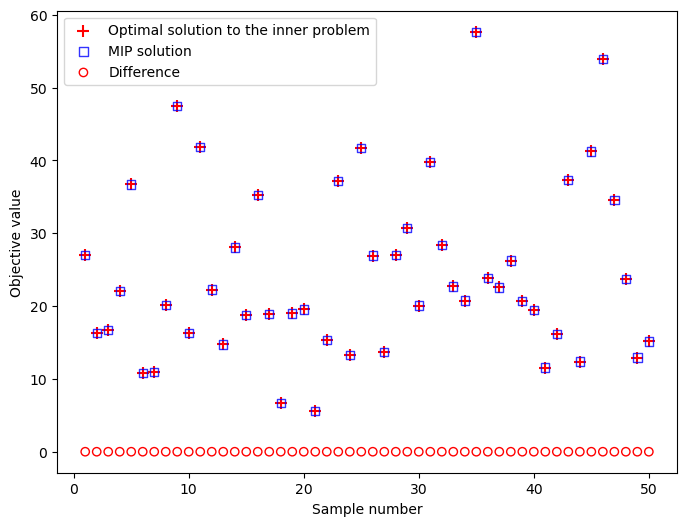

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we need to generate similar data for demonstration
np.random.seed(0)
sample_number = np.arange(1, len(error)+1)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(sample_number, opt_list, color='r', marker='+', s=70, label='Optimal solution to the inner problem')
plt.scatter(sample_number, lb_list, facecolors='none', edgecolors='b', alpha=0.8, marker='s', label='MIP solution')
plt.scatter(sample_number, error, facecolors='none', edgecolors='r', marker='o', label='Difference')

# Labeling the axes and the plot
plt.xlabel('Sample number')
plt.ylabel('Objective value')

# Adding a legend to the plot
plt.legend()

# Show the plot
# plt.savefig("toy_example.png", dpi=300, bbox_inches='tight')
plt.show()